# Aux 1
## AS4501-1 Astroinformatics

Profs: Valentino Gonzalez, Francisco Forster.

T.A: Melissa Fuentealba.

# Contents

- Bayes' Theorem
- PyMC3 
- Confidence Intervals


# Bayes' Theorem 

This theorem describes a method to update probabilities based on data and past knowledge.

$\textbf{X}$: Observed data.

$\hat\theta$: Parameter vector.

$\textbf{M}$: Model.

$$ \large P(\hat\theta|X,M) = \frac{P(X|\hat\theta,M) P(\hat\theta|M)}{P(X|M)} $$

$\bigstar$ $P(X|\hat\theta,M)$ is the likelihood function, it describes the joint probability of the observed data as a function of the parameters of the chosen statistical model.

$\bigstar$  $P(\hat\theta|M)$ is the prior, an initial probability distribution that is assigned to the parameters, without further evidence.

$\bigstar$  $P(X|M)$ is the marginalized distribution of the dataset over all parameter values in model M, also called marginal likelihood or model evidence BUT this parameter can be very hard to compute in many cases. For this reason, we disregard it and uses as a normalization factor.

$\bigstar$  $P(\hat\theta|X,M)$ is the posterior distribution (what we want).


# Bayesian Inference over Frequentist Statistics

There are 2 main approaches to statistical inference, Frequentist and Bayesian, differing in their interpretation of uncertainty. 

The frequentist approach deals with long-run probabilities (how probable is this data set given the null hypothesis), whereas the Bayesian approach deals with the probability of a hypothesis given a particular data set.

Bayesian statistics advantages:

- Bayesian analysis incorporates prior information into the analysis, whereas a frequentist analysis is purely driven by the data.

- Bayesian estimates provide a posterior distribution from which we can compute a number of statistics.

For the following example, we will try to do a Markov Chain Monte Carlo using a very friendly library called PyMC3. You can install it with $\textbf{pip install pymc3}$ or with conda through $\textbf{conda install -c conda-forge pymc3}$.

In [31]:
import pymc3 as pm
print(f'Running PyMC3 v{pm.__version__}')

Running PyMC3 v3.11.5


We import some basic libraries:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Example


### The Data

We are going to use a supernova (SN) light curve from the Zwicky Transient Facility (ZTF) catalog. A light curve is the representation of the flux emitted by an object within a time interval (each point of the curve corresponds to a detection). 

<img src="lcs.gif">

In the case of supernovae, their light curves vary within the different types of classification and the objective is to find a model that is able to fit all of them, so their light curves can be identified and clasified separately from the light curves of other objects.

<img src="sntyp.gif">

In the ZTF sample there are 4 different types: SLSN, SNII, SNIa, SNIbc.

In our example we will select one of them and try to fit its light curve using a model.


### The Model

The model that we will try is based on the parametric model of $\textbf{Villar et al. 2019}$ (arXiv:1905.07422), which has 7 free parameters: 


\begin{equation}
\label{modelo_f}\Large
    F = \begin{cases}
        \frac{A (1 - f\frac{(t - t_0)}{\gamma})} {1 + e^{-(t - t_0) / \tau_{\rm rise}}} & \mbox{if} \: t < t_1 
        \\
        \frac{A(1-f){\rm e}^{-(t - t_1) / \tau_{\rm fall}}}{1 + {e}^{-(t - t_0) / \tau_{\rm rise}}} & \mbox{if} \: t \ge t_1 
        \end{cases}
\end{equation}                                                                                                   


where:

$A$ : models the amplitude of the curve

$f$ : This is  a reparametrization from Villar parameter "$\beta$" (That's why we say that is a modified version of her model)

$t_0$ : defines the temporal change of the curve

$t_1$ : controls the beginning of the plateau (seen in Type II SNe)

$\tau_{rise}$ : affects the rise of the curve

$\tau_{fall}$ : affects the decay of the curve

$\gamma$ : is a reparameterization of $t_1$ - $t_0$

In [3]:
def Model(t, A, f, t_0, gamma, tau_r, tau_f): 
    return np.piecewise(t, [t < gamma+t_0, t >= gamma+t_0],
                        [lambda t: 1.0*(A*(1 - (f*(t - t_0)/gamma))/(1 + np.exp(-(t - t_0)/tau_r))),
                         lambda t:1.0*(A*(1 - f)*np.exp(-(t - (gamma + t_0))/tau_f)/(1 + 
                                                            np.exp(-(t - t_0)/tau_r)))])

Given a set of conditions and corresponding functions, $\textbf{numpy piecewise}$ evaluate each function on the input data wherever its condition is true.

# Our Code

The original ZTF sample has 89.751 detections of different SNe.

In [4]:
df_ZTF = pd.read_csv("detections_SN_updated.csv")
df_ZTF.head()

,oid,candid,mjd,fid,field,rcid,sigmapsf,magpsf,isdiffpos
0,ZTF19abvbraf,976150903515015176,58730.150903,2,542,35,0.052121,17.880810,1
1,ZTF19abvbraf,976243643515015094,58730.243646,1,542,35,0.067821,17.678339,1
2,ZTF19abvbraf,978233514615015022,58732.233518,2,543,46,0.060633,18.167953,1
3,ZTF19abvbraf,978303734615015028,58732.303738,1,543,46,0.061428,17.973301,1
4,ZTF19abvbraf,979231303515015082,58733.231308,2,542,35,0.057161,18.228895,1


In [5]:
len(df_ZTF)

89751

### ZTF19abmylxw

We choose the SN ZTF19abmylxw which has 50 detections (points in the light curve) and we convert the magnitude column into flux using:

$$ \large F = 10^{\frac{-(Mag + 48.6)}{2.5}} $$ 

In [6]:
df = pd.read_csv("SN.csv")
df.head()

,mjd,F,F_err
0,58711.206285,0.502005,0.025592
1,58710.206910,0.474387,0.024543
2,58709.233588,0.453048,0.022119
3,58708.234005,0.402788,0.016464
4,58707.232824,0.364255,0.015124


In [7]:
len(df)

50

In [8]:
t = df['mjd'].values
F = df['F'].values
F_err = df['F_err'].values

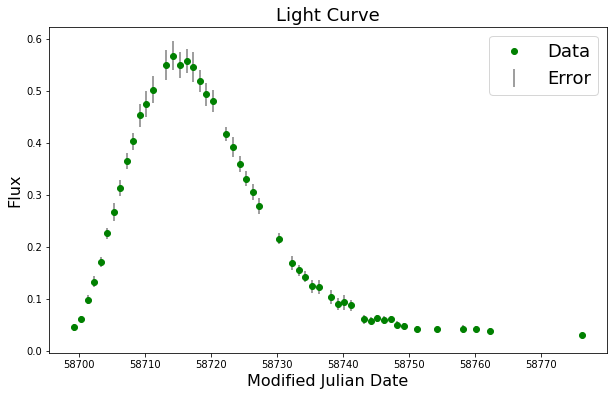

In [9]:
plt.figure(figsize=(10,6))

plt.plot(t,F,'go', label = 'Data')
plt.errorbar(t, F, yerr = F_err, fmt='None',ecolor='gray', label = 'Error')

plt.title('Light Curve',size=18)
plt.xlabel('Modified Julian Date',size=16)
plt.ylabel('Flux', size=16)
plt.legend(loc= 1, frameon=True, prop={'size':18})
plt.show('off')

### Prior

For the prior distribution of the parameters we are going to use:

| $Parameter$ | $Prior$ | 
| --- | --- | 
| $A$ | $U (0, 5·F_{max})$| 
| $t_0$ | $U (t_{max} - 40, t_{max} + 60)$ | 
| $f$ | $U (0, 1)$ | 
| $\tau_{rise}$ | $U (1, 30)$ |
| $\tau_{fall}$ | $U (1, 70)$ |
| $\gamma$ | $N (35, 10)$ |

This distributions are based on Villar's work but had been slightly changed to have better results for our sample.

In [10]:
index = np.where(F == max(F))[0][0]
t_max = t[index]
F_max = max(F)
print('Index: ' + str(index))
print('t_max: ' + str(t_max))
print('F_max: ' + str(F_max))

Index: 14
t_max: 58714.2068634001
F_max: 0.5671352951182645


### Sigmoid Function

Is a mathematical function having a characteristic "S"-shaped curve.

<img src="sigmoid_function.png" width="400">

$$ Sigmoid(x) = \frac{1}{1 - e^{-x}} $$

$$ Sigmoid(x) = Sigmoid(x)·[1 - Sigmoid(x)] $$

We are going to use it in order to make a smooth transition between the two sections of Villar parametrization. 

In [11]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

In [12]:
model = pm.Model()

# 1) Model
with model as MyModel:
    
    # 2) Prior    
    A = pm.Uniform('A', 0 , 5*max(F))
    t_0 = pm.Uniform('t_0', t_max - 40 , t_max + 60)
    f = pm.Uniform('f', 0 , 1)
    tau_r = pm.Uniform('tau_r', 1 , 30)
    tau_f = pm.Uniform('tau_f', 1,  70)
    gamma = pm.Normal('gamma', 35, 10)     

    # Villar's Function    
    early =  1.0*(A*(1-(f*(t - t_0)/gamma))/(1 + np.exp(-(t - t_0)/tau_r)))*(1 - sigmoid((t-(gamma+t_0))/3))   
    late = 1.0*(A*(1-f)*np.exp(-(t - (gamma+t_0))/tau_f)/(1 + np.exp(-(t - t_0)/tau_r)))*sigmoid((t-(gamma+t_0))/3)

    function = early + late
    
    # 3) Likelihood
    L = pm.Normal('likelihood', function, sigma= F_err, observed= F)

    # 4) Step
    step = pm.NUTS(target_accept = 0.95)
    
    # 5) Trace
    trace = pm.sample(1500, step, chains=2, tune=500, return_inferencedata=True)

Multiprocess sampling (2 chains in 4 jobs)
NUTS: [gamma, tau_f, tau_r, f, t_0, A]


Sampling 2 chains for 500 tune and 1_500 draw iterations (1_000 + 3_000 draws total) took 8 seconds.


### 1) with model as MyModel

Creates a new Model object which is a container for the model random variables. Using $\textbf{with}$ creates a context manager, with our basic_model as the context, that includes all statements until the indented block ends. This means all PyMC3 objects introduced in the indented code block below the with statement are added to the model behind the scenes. 

### 2) Prior

- pm.Uniform('tau_r', 1, 30) creates a stochastic random variable with a Uniform prior distribution with a lower and upper boundary of 1 and 30, respectively. 

- pm.Normal('gamma', 35, 10) is a Normal prior distribution with a mean of 35 and standard deviation of 10.

### 3) Likelihood

- pm.Normal('likelihood', function, sigma= F_err, observed=F): This line of the model, defines the sampling distribution of the outcomes in the dataset. Includes the observed data and the errors in the measurement.

### 4) Step

Tto generate posterior samples in PyMC3, we specify a step method object that corresponds to a particular MCMC algorithm, such as Metropolis, Slice sampling, or the No-U-Turn Sampler (NUTS).
These step methods can be assigned manually, or assigned automatically by PyMC3. Auto-assignment is based on the attributes of each variable in the model. In general:

- Binary variables will be assigned to BinaryMetropolis

- Discrete variables will be assigned to Metropolis

- Continuous variables will be assigned to NUTS

Target_accept: Adapt the step size such that the average acceptance probability across the trajectories are close to target_accept. Higher values for target_accept lead to smaller step sizes. Setting this to higher values like 0.9 or 0.99 can help with sampling from difficult posteriors. 


### Maximum a Posteriori

The maximum a posteriori (MAP) estimate for a model, is the mode of the posterior distribution and is generally found using numerical optimization methods. This is often fast and easy to do, but only gives a point estimate for the parameters and can be biased if the mode isn’t representative of the distribution. 

In [13]:
map_estimate = pm.find_MAP(model= MyModel)
map_estimate

{'A_interval__': array(-1.01054599),
 't_0_interval__': array(-0.69742095),
 'f_interval__': array(1.78093294),
 'tau_r_interval__': array(-2.67842774),
 'tau_f_interval__': array(-0.86712261),
 'gamma': array(28.3978918),
 'A': array(0.75676553),
 't_0': array(58707.44529177),
 'f': array(0.85581203),
 'tau_r': array(2.86349216),
 'tau_f': array(21.41388316)}

### 5 ) Trace

An object containing the samples collected, in the order they were collected. The trace object can be queried in a similar way to a dict containing a map from variable names to numpy.arrays. 

- $\textbf{tune}$ = 500: The first 500 tuning samples are discarded, as it would be theoretically shaky ground to suggest they came from the stationary distribution at all. 

In [14]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [15]:
trace.sample_stats

<xarray.Dataset>
Dimensions:             (chain: 2, draw: 1500)
Coordinates:
  * chain               (chain) int64 0 1
  * draw                (draw) int64 0 1 2 3 4 5 ... 1495 1496 1497 1498 1499
Data variables: (12/13)
    perf_counter_diff   (chain, draw) float64 0.004338 0.002041 ... 0.001051
    process_time_diff   (chain, draw) float64 0.004338 0.00204 ... 0.001051
    n_steps             (chain, draw) float64 31.0 15.0 31.0 ... 15.0 31.0 7.0
    lp                  (chain, draw) float64 134.1 136.5 135.8 ... 133.2 132.6
    acceptance_rate     (chain, draw) float64 0.999 1.0 0.963 ... 0.8095 1.0
    energy_error        (chain, draw) float64 -0.313 -0.15 ... 0.1264 -0.01273
    ...                  ...
    max_energy_error    (chain, draw) float64 -0.5152 -0.2414 ... 0.7238 -0.302
    perf_counter_start  (chain, draw) float64 9.77e+03 9.77e+03 ... 9.775e+03
    step_size_bar       (chain, draw) float64 0.1301 0.1301 ... 0.1547 0.1547
    tree_depth          (chain, draw) int64 5 4 5 2 4 4 2 4 ... 6 4 6 4 6 4 5 3
    energy              (chain, draw) float64 -129.8 -132.8 ... -128.2 -130.5
    step_size           (chain, draw) float64 0.1382 0.1382 ... 0.1774 0.1774
Attributes:
    created_at:                 2022-08-22T19:12:48.081688
    arviz_version:              0.12.1
    inference_library:          pymc3
    inference_library_version:  3.11.5
    sampling_time:              7.941962003707886
    tuning_steps:               500

### Posterior Analysis
- The left column consists of a smoothed histogram (using kernel density estimation) of the marginal posteriors of each stochastic random variable. 

- The right column contains the samples of the Markov chain plotted in sequential order. 

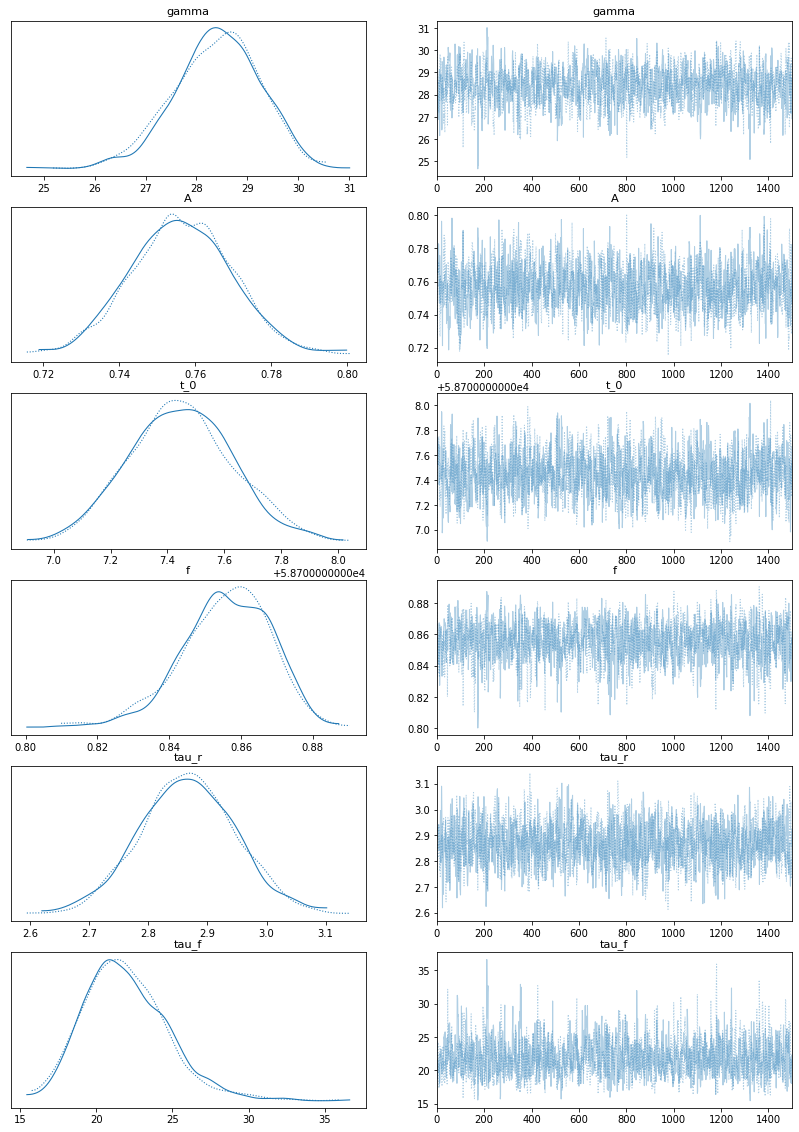

In [16]:
pm.plot_trace(trace, figsize= [14,20], divergences='bottom')
plt.show('off')

### How can we save the trace?

We can use the library $\textbf{pickle}$ to save the trace, the MAP, and the model in case you want to use the results without running the code all over again, as it can take a long time sometimes depending in the number of iterations you are using.

In [17]:
import pickle

# To save the trace
with open( 'MyTrace.dat', 'wb' ) as mcmc :
    pickle.dump({'model': MyModel , 'trace': trace, 'map': map_estimate}, mcmc)

# Loading the trace    
with open( 'MyTrace.dat', 'rb' ) as mcmc:
    data = pickle.load(mcmc)  
MyModel, trace, map_estimate = data['model'], data['trace'], data['map']

In [18]:
tau_r = trace.posterior['tau_r'].values
tau_f = trace.posterior['tau_f'].values
t_0 = trace.posterior['t_0'].values
A = trace.posterior['A'].values
f = trace.posterior['f'].values
gamma = trace.posterior['gamma'].values

In [19]:
np.shape(tau_r), tau_r   

((2, 1500),
 array([[2.92335211, 2.88912699, 2.91732561, ..., 2.8562657 , 2.9168521 ,
         2.92535354],
        [2.8064644 , 2.59383043, 2.82439359, ..., 2.81038778, 2.75665206,
         2.73991703]]))

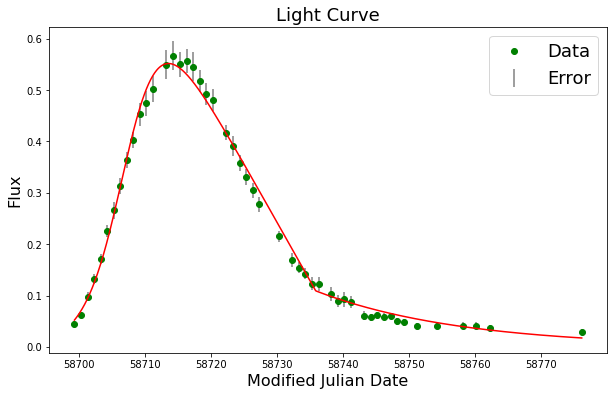

In [20]:
plt.figure(figsize=(10,6))

plt.plot(t,F,'go', label = 'Data')
plt.errorbar(t, F, yerr = F_err, fmt='None',ecolor= 'gray', label = 'Error')

t_ls = np.linspace(min(t),t[len(t)-1],1000)
plt.plot(t_ls, Model(t_ls, A.mean(), f.mean(), t_0.mean(), gamma.mean(), tau_r.mean(), tau_f.mean()), 'r')

plt.title('Light Curve',size=18)
plt.xlabel('Modified Julian Date',size=16)
plt.ylabel('Flux', size=16)
plt.legend(loc= 1, frameon=True, prop={'size':18})
plt.show('off')

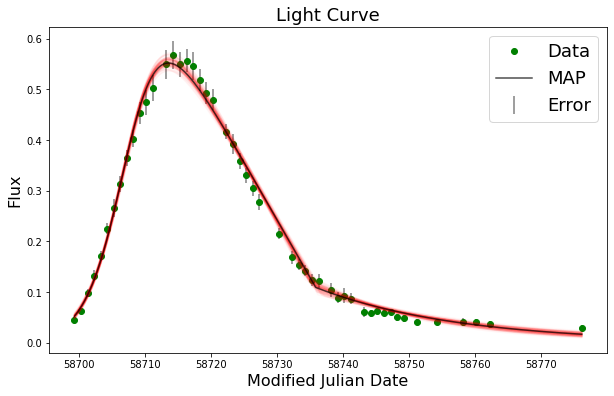

In [21]:
plt.figure(figsize=(10,6))

plt.plot(t,F,'o', color ='g', label = 'Data')
plt.errorbar(t, F, yerr = F_err, fmt='None',ecolor= 'gray', label='Error')

for i in range(1300,1400):
    plt.plot(t_ls, Model(t_ls, trace.posterior['A'].values[0][i], trace.posterior['f'].values[0][i], 
             trace.posterior['t_0'].values[0][i], trace.posterior['gamma'].values[0][i], 
             trace.posterior['tau_r'].values[0][i], trace.posterior['tau_f'].values[0][i]), 
             'r', alpha=0.03)

#MAP Plot
plt.plot(t_ls, Model(t_ls, map_estimate['A'], map_estimate['f'], map_estimate['t_0'],
                      map_estimate['gamma'], map_estimate['tau_r'], map_estimate['tau_f']), 'k', 
         alpha= 0.7, label = 'MAP')

plt.title('Light Curve', size=18)
plt.xlabel('Modified Julian Date',size=16)
plt.ylabel('Flux', size=16)
plt.legend(loc= 1, frameon=True, prop={'size':18})

### Corner plot

The corner plot shows all the one and two dimensional projections of the posterior probability distributions of your parameters. This is useful because it quickly demonstrates all of the covariances between parameters.

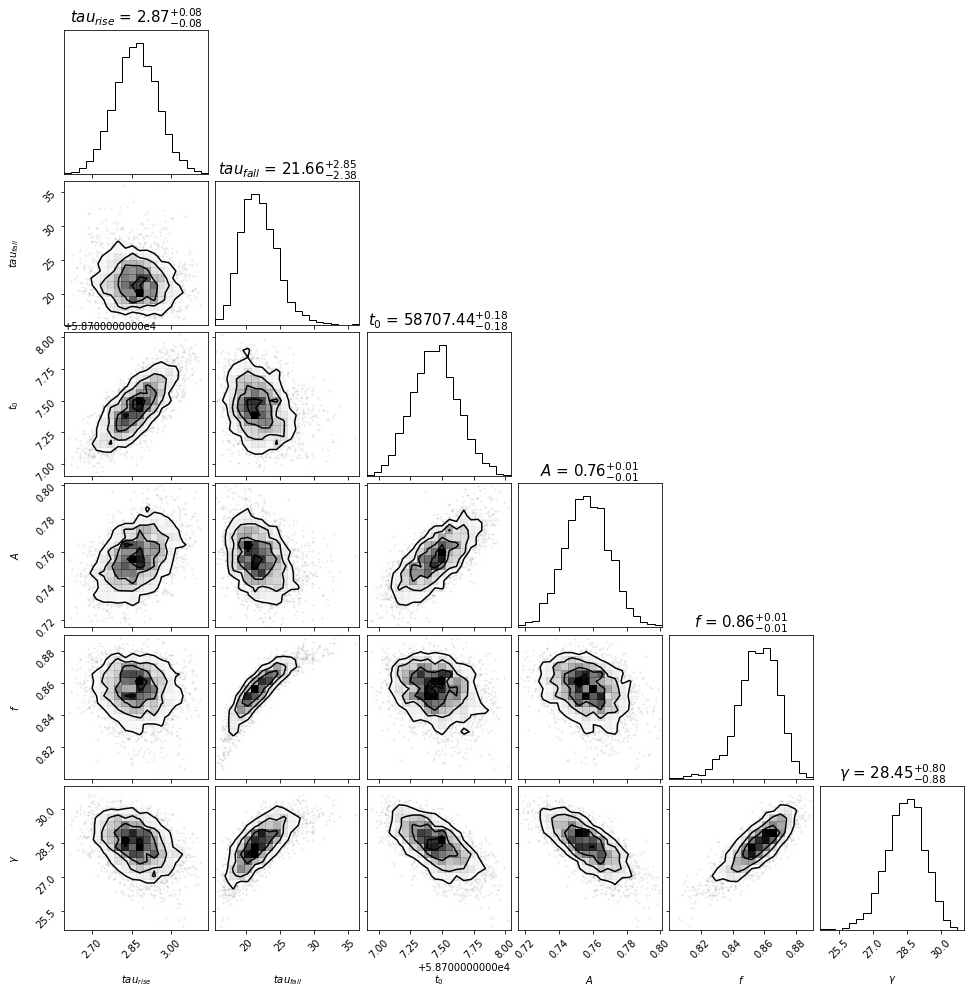

In [22]:
import corner

tau_r_t = np.array(tau_r).T
tau_f_t = np.array(tau_f).T
t_0_t = np.array(t_0).T
A_t = np.array(A).T
f_t = np.array(f).T
gamma_t = np.array(gamma).T
samples = np.array([tau_r_t, tau_f_t, t_0_t, A_t, f_t, gamma_t]).T
figure = corner.corner(samples, labels=['$tau_{rise}$', '$tau_{fall}$', '$t_0$', '$A$', '$f$', '$\gamma$'], 
                       show_titles=True, title_kwargs={"fontsize": 15})

In [23]:
np.shape(tau_r), np.shape(samples)

((2, 1500), (2, 1500, 6))

### Other libraries to work with MCMC

- emcee: You can install it with  $\textbf{pip install -U emcee}$ or using $\textbf{conda install -c conda-forge emcee}$

# Confidence Intervals

Confidence interval (CI) is a range of estimates for an unknown parameter. A confidence interval is computed at a designated confidence level.

Your desired confidence level is usually one minus the alpha ($\alpha$) value you used in your statistical test:

Confidence level (CL) = 1 − $\alpha$ 

So if you use an $\alpha$ value of p < 0.05 for statistical significance, then your confidence level would be 1 − 0.05 = 0.95, or 95%. This means you are confident that 95 out of 100 times the estimate will fall between the upper and lower values specified by the confidence interval (CI).

The 95% confidence level is most common, but other levels, such as 90% or 99%, are sometimes used.

In [24]:
from scipy.special import erf

def ci(post, cl):
    """
    Parameters:
    post : array_like
        The posterior sample over which to calculate the bayesian credibility interval.
    cl: float
        Confidence level (in percentage).
    --------
    Returns:
    low : float
        Lower part of the confidence interval.
    up : float
        Upper part of the confidence interval.
    """
    alpha = (100 - cl)/2     # /2 for two tailed 
    lower_percentile = alpha
    upper_percentile = 100 - alpha
    
    # np.percentile(a,q): returns the q-th percentile(s) of the array elements "a".
    low, up = np.percentile(post, [lower_percentile, upper_percentile])
    return low, up

In [25]:
trace.posterior['A'].values.min() , trace.posterior['A'].values.max()

(0.7155737598817622, 0.8007849522830506)

In [26]:
low_A, up_A = ci(trace.posterior['A'], 68)
low_A, up_A

(0.7429937858938478, 0.7697716147128799)

In [27]:
# The most common
low_A, up_A = ci(trace.posterior['A'], 95)
low_A, up_A

(0.7308287205036528, 0.7829414394928073)

In [28]:
low_A, up_A = ci(trace.posterior['A'], 90)
low_A, up_A

(0.7345987440835371, 0.7785406738481425)

In [29]:
low_A, up_A = ci(trace.posterior['A'], 99)
low_A, up_A

(0.7216818470885231, 0.7932482258530604)

In [30]:
low_A, up_A = ci(trace.posterior['A'], 100)
low_A, up_A

(0.7155737598817622, 0.8007849522830506)